<a href="https://colab.research.google.com/github/natzasu13/microexpresion-recognition/blob/timeDistributed_CASMEII/timeDistributedExample_KERAS_CASMEII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

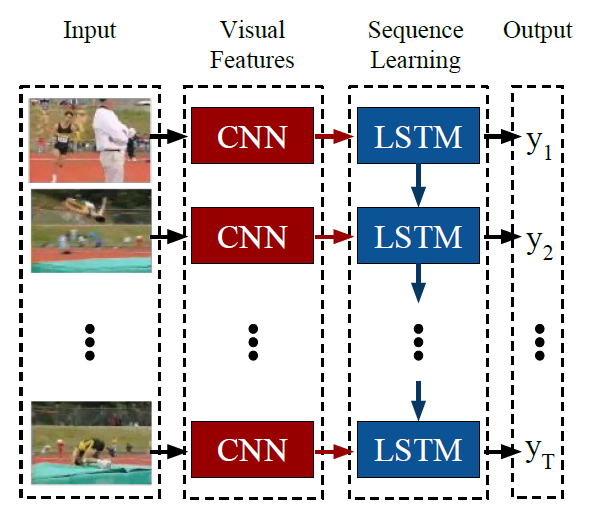

In [ ]:
import keras
from keras.layers import Input ,Dense, Dropout, Activation, LSTM
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling1D
#from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model

import numpy as np

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = '/content/drive/MyDrive/TesisMScNataliaZartha/'
import numpy as np
from sklearn.model_selection import train_test_split

X = np.squeeze(np.load(ruta+'microexpstcnn_images_tr_casmeII.npy'))
t = np.squeeze(np.load(ruta+'microexpstcnn_labels_tr_casmeII.npy'))

X = np.moveaxis(X, -1, 1)


img = np.squeeze(X)/255.
lbl = t

X_train, X_val, y_train, y_val = train_test_split(img,lbl,test_size = 0.4,random_state = 123)

X_train = np.expand_dims(X_train,axis= 0)
X_train = np.moveaxis(X_train, 0, -1)

X_val = np.expand_dims(X_val,axis= 0)
X_val = np.moveaxis(X_val, 0, -1)


print(X_val.shape)

(103, 18, 64, 64, 1)


In [ ]:
#%%
num_frames = 18
width = 64
height = 64
num_classes = 3


model = Sequential()

model.add(
    TimeDistributed(
        Convolution2D(64, (3, 3), activation='relu'), 
        input_shape=(num_frames, width, height, 1)
    )
)
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))))

model.add(TimeDistributed(Convolution2D(128, (4,4), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(256, (4,4), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# extract features and dropout 
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))

# input to LSTM
model.add(LSTM(256, return_sequences=False, dropout=0.5))

# classifier with sigmoid activation for multilabel
model.add(Dense(num_classes, activation='softmax'))
model.summary()
#%%


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 62, 62, 64)    640       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 61, 61, 64)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 58, 58, 128)   131200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 29, 29, 128)   0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 26, 26, 256)   524544    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 13, 13, 256)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 43264)         0

In [ ]:
from tensorflow import keras

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    #optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    ruta+"3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="acc", patience=25)

# Train the model, doing validation at the end of each epoch
epochs = 1000
model.fit(X_train,y_train,
          validation_data=(X_val,y_val),
          epochs=epochs,
          shuffle=True,
          verbose=2,
          callbacks=[checkpoint_cb,early_stopping_cb],
)


Epoch 1/1000
5/5 - 69s - loss: 1.0190 - acc: 0.3896 - val_loss: 1.0322 - val_acc: 0.6505
Epoch 2/1000
5/5 - 7s - loss: 0.9592 - acc: 0.5390 - val_loss: 0.9842 - val_acc: 0.5049
Epoch 3/1000
5/5 - 7s - loss: 0.9286 - acc: 0.5714 - val_loss: 0.9774 - val_acc: 0.7379
Epoch 4/1000
5/5 - 7s - loss: 0.8918 - acc: 0.6753 - val_loss: 0.8970 - val_acc: 0.5340
Epoch 5/1000
5/5 - 7s - loss: 0.8305 - acc: 0.5909 - val_loss: 0.8365 - val_acc: 0.7379
Epoch 6/1000
5/5 - 7s - loss: 0.7087 - acc: 0.7532 - val_loss: 0.5717 - val_acc: 0.7476
Epoch 7/1000
5/5 - 7s - loss: 0.5508 - acc: 0.7532 - val_loss: 0.3880 - val_acc: 0.8155
Epoch 8/1000
5/5 - 7s - loss: 0.4414 - acc: 0.8506 - val_loss: 0.5795 - val_acc: 0.7864
Epoch 9/1000
5/5 - 7s - loss: 0.3699 - acc: 0.8701 - val_loss: 0.4029 - val_acc: 0.8447
Epoch 10/1000
5/5 - 7s - loss: 0.3504 - acc: 0.8701 - val_loss: 0.2818 - val_acc: 0.8835
Epoch 11/1000
5/5 - 7s - loss: 0.2211 - acc: 0.9156 - val_loss: 0.3029 - val_acc: 0.8350
Epoch 12/1000
5/5 - 7s - loss

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


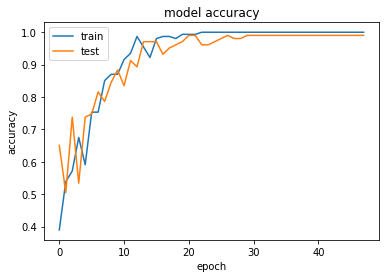

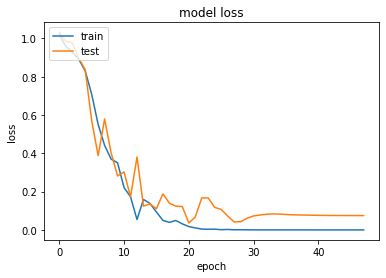

In [ ]:
import matplotlib.pyplot as plt
history = model.history
# Trainig Process
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Evaluation

Acc Val: 0.9902912621359223


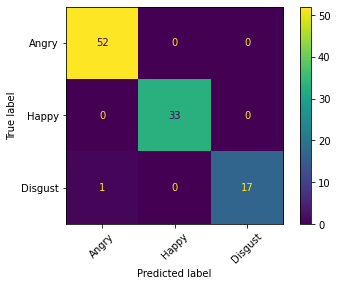

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

yEst_val = model.predict(X_val)

tEst_val = np.argmax(yEst_val,axis=1)
t_val = np.argmax(y_val,axis=1)

print('Acc Val:',accuracy_score(t_val,tEst_val))

cMat_val = confusion_matrix(t_val,tEst_val)

ax = ConfusionMatrixDisplay(cMat_val,display_labels= ["Angry", "Happy","Disgust"])
ax.plot(xticks_rotation = 45)

In [ ]:
scores = yEst_val[0]
class_names = ["Negativo", "Positivo","Sorpresa"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that Emotional sequence is %s"
        % ((100 * score), name)
    )

print('Real Label: ',y_val[0])

This model is 99.98 percent confident that Emotional sequence is Negativo
This model is 0.00 percent confident that Emotional sequence is Positivo
This model is 0.01 percent confident that Emotional sequence is Sorpresa
Real Label:  [1. 0. 0.]


#ROC and Precision-Recall curves

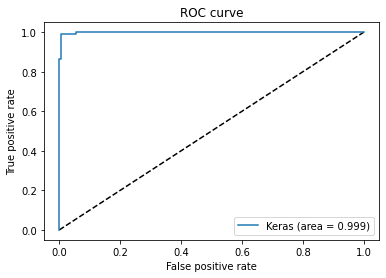

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, hamming_loss, jaccard_similarity_score, log_loss, zero_one_loss, matthews_corrcoef, confusion_matrix, accuracy_score, classification_report, precision_recall_curve, roc_curve, auc

#https://webmonkez.com/questions/1637057/como-encontrar-la-curva-roc-y-la-puntuacion-auc-del-modelo-cnn-keras

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val.ravel(), yEst_val.ravel())

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()